<a href="https://colab.research.google.com/github/kevinszuchet/waste-classification/blob/main/Non_and_Biodegradable_Classification_1st_2nd_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Images

Kaggle Dataset: https://www.kaggle.com/rayhanzamzamy/non-and-biodegradable-waste-dataset

## Fetch dataset from Kaggle

In [ ]:
! mkdir -p ~/.kaggle;
! cp kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d rayhanzamzamy/non-and-biodegradable-waste-dataset

 99% 1.85G/1.86G [00:12<00:00, 196MB/s]
100% 1.86G/1.86G [00:12<00:00, 165MB/s]


In [ ]:
! unzip non-and-biodegradable-waste-dataset.zip -d non_and_biodegradable_waste_dataset

Streaming output truncated to the last 5000 lines.
  inflating: non_and_biodegradable_waste_dataset/TRAIN.4/N/TRAIN.4_NBIODEG_VFL_180.jpg  
  inflating: non_and_biodegradable_waste_dataset/TRAIN.4/N/TRAIN.4_NBIODEG_VFL_1800.jpg  
  inflating: non_and_biodegradable_waste_dataset/TRAIN.4/N/TRAIN.4_NBIODEG_VFL_1801.jpg  
  inflating: non_and_biodegradable_waste_dataset/TRAIN.4/N/TRAIN.4_NBIODEG_VFL_1802.jpg  
  inflating: non_and_biodegradable_waste_dataset/TRAIN.4/N/TRAIN.4_NBIODEG_VFL_1803.jpg  
  inflating: non_and_biodegradable_waste_dataset/TRAIN.4/N/TRAIN.4_NBIODEG_VFL_1804.jpg  
  inflating: non_and_biodegradable_waste_dataset/TRAIN.4/N/TRAIN.4_NBIODEG_VFL_1805.jpg  
  inflating: non_and_biodegradable_waste_dataset/TRAIN.4/N/TRAIN.4_NBIODEG_VFL_1806.jpg  
  inflating: non_and_biodegradable_waste_dataset/TRAIN.4/N/TRAIN.4_NBIODEG_VFL_1807.jpg  
  inflating: non_and_biodegradable_waste_dataset/TRAIN.4/N/TRAIN.4_NBIODEG_VFL_1808.jpg  
  inflating: non_and_biodegradable_waste_dataset/T

In [ ]:
! mkdir -p non_and_biodegradable_waste_dataset/TRAIN/B non_and_biodegradable_waste_dataset/TRAIN/N

! find non_and_biodegradable_waste_dataset/TRAIN.1/B -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/B '{}' +
! find non_and_biodegradable_waste_dataset/TRAIN.1/N -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/N '{}' +

! find non_and_biodegradable_waste_dataset/TRAIN.2/B -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/B '{}' +
! find non_and_biodegradable_waste_dataset/TRAIN.2/N -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/N '{}' +

! find non_and_biodegradable_waste_dataset/TRAIN.3/B -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/B '{}' +
! find non_and_biodegradable_waste_dataset/TRAIN.3/N -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/N '{}' +

! find non_and_biodegradable_waste_dataset/TRAIN.4/B -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/B '{}' +
! find non_and_biodegradable_waste_dataset/TRAIN.4/N -name '*.*' -exec mv --target-directory=non_and_biodegradable_waste_dataset/TRAIN/N '{}' +

In [ ]:
! rm -rf non_and_biodegradable_waste_dataset/TRAIN.*

## Fetch saved models from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! cp 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/baseline-model.h5' .
! cp 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/vgg16-model.h5' .
! cp 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/efficientnet-model.h5' .
! cp 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/inception-v3-model.h5' .

In [ ]:
drive.flush_and_unmount()

# Data Exploration

Some ideas:
- Plot some histograms with the contrast of the images
- Detect some edges in the images trying to think in the future. Will be we able to detect from each image which object is biodegradable and which not?
- ...
- Plot the future NN using https://github.com/alexlenail/NN-SVG and Graphext
- https://www.linkedin.com/posts/philipvollet_datascience-deeplearning-machinelearning-activity-6891784784658735104-rNC-/
- UI with https://www.youtube.com/watch?v=RiCQzBluTxU&list=PLXROitT1fqQyCrPclagPBO7F2OCzQEsDd&index=11

In [ ]:
! pip install tensorflow-addons -q

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, classification_report
from tensorflow.keras.optimizers import RMSprop, SGD

# https://www.tensorflow.org/datasets/performances
# https://www.tensorflow.org/guide/data_performance

AUTOTUNE = tf.data.AUTOTUNE

## Globals Setup

In [ ]:
root_dir = '/content/non_and_biodegradable_waste_dataset/'

# Training Subset Directories (1 dim array of directories)
train_dir = os.path.join(root_dir, 'TRAIN')
# Test Subset Directory
test_dir = os.path.join(root_dir, 'TEST')

batch_size = 32
seed = 42

# Output image size
image_size = (64, 64)

# Fraction for Validation Subset (0.2 = 20% of Training Subset)
val_split = 0.2

color_mode = 'rgb'

In [ ]:
def display_img(src, ax=None):
  if ax is None:
    f, ax = plt.subplots()

  img = plt.imread(src)
  ax.imshow(img)
  ax.set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
  return img

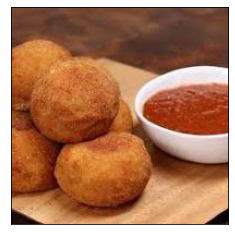

In [ ]:
src = os.path.join(test_dir, 'B/TEST_BIODEG_HFL_1013.jpg')
img = display_img(src)

In [ ]:
img.shape

(200, 200, 3)

## Datasets generator

In [ ]:
# Set Up Dataset converting images from Directory to tf.data.Dataset() Object.

train_ds = image_dataset_from_directory(
  directory=train_dir,
  label_mode='binary',
  labels='inferred',
  color_mode=color_mode,
  seed=seed,
  validation_split=0.2,
  subset='training',
  image_size=image_size,
  batch_size=batch_size)

val_ds = image_dataset_from_directory(
  directory=train_dir,
  label_mode='binary',
  labels='inferred',
  color_mode=color_mode,
  seed=seed,
  validation_split=0.2,
  subset='validation',
  image_size=image_size,
  batch_size=batch_size)

Found 239690 files belonging to 2 classes.
Using 191752 files for training.
Found 239690 files belonging to 2 classes.
Using 47938 files for validation.


## EDA

Exploratory data analysis comprises of brief analyses to describe a dataset to guide the modeling process and to answer preliminary questions. For classification problems, this might include looking at the distributions of variables or checking for any meaningful patterns of predictors across different classes. The same problem holds for the classification of image data. We intend to find meaningful information simple operations can give us.

Here there are some interesting ideas but we would need the data as a numpy array and the size of the dataset is pretty big to apply numpy operations in memory. https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

---

Here we also could get interesting insights of how to explore our dataset https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection

In [ ]:
class_names = train_ds.class_names
print(class_names)

['B', 'N']


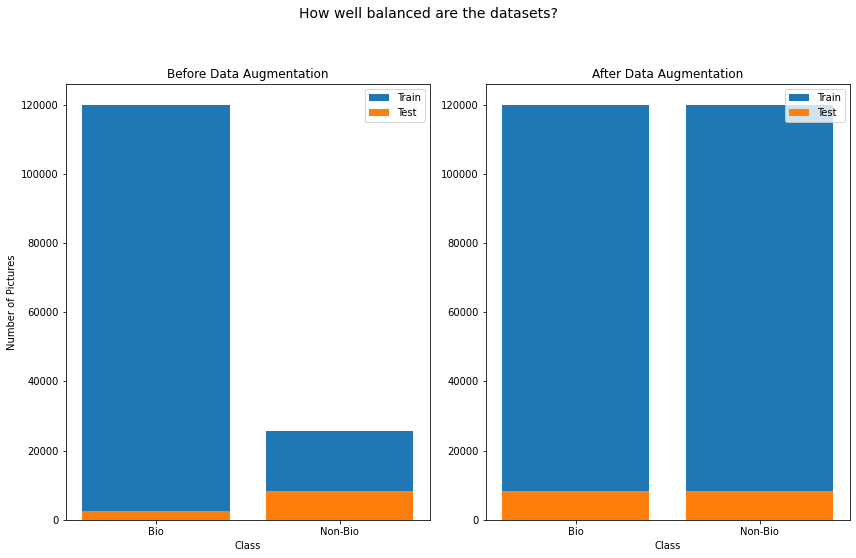

In [ ]:
f, (ax_bfda, ax_afda) = plt.subplots(1, 2, figsize=(12, 7))

# Get the list of images from sub image class folders
b_train_dir, n_train_dir = os.listdir(f'{train_dir}/B'), os.listdir(f'{train_dir}/N')
b_test_dir, n_test_dir = os.listdir(f'{test_dir}/B'), os.listdir(f'{test_dir}/N')

# bfda: Before Data Augmentation
train_bio_images_bfda, train_non_bio_images_bfda = [fn for fn in b_train_dir if "ORI" in fn], [fn for fn in n_train_dir if "ORI" in fn]
test_bio_images_bfda, test_non_bio_images_bfda = [fn for fn in b_test_dir if "ORI" in fn], [fn for fn in n_test_dir if "ORI" in fn]

# afda: After Data Augmentation
train_bio_images_afda, train_non_bio_images_afda = [fn for fn in b_train_dir], [fn for fn in n_train_dir]
test_bio_images_afda, test_non_bio_images_afda = [fn for fn in b_test_dir], [fn for fn in n_test_dir]

ax_bfda.set_ylabel('Number of Pictures')

ax_bfda.bar(['Bio', 'Non-Bio'], [len(train_bio_images_bfda), len(train_non_bio_images_bfda)], label="Train")
ax_bfda.bar(['Bio', 'Non-Bio'], [len(test_bio_images_bfda), len(test_non_bio_images_bfda)], label="Test")
ax_bfda.legend()
ax_bfda.set(xlabel='Class', title='Before Data Augmentation')

ax_afda.bar(['Bio', 'Non-Bio'], [len(train_bio_images_afda), len(train_non_bio_images_afda)], label="Train")
ax_afda.bar(['Bio', 'Non-Bio'], [len(test_bio_images_afda), len(test_non_bio_images_afda)], label="Test")
ax_afda.legend()
ax_afda.set(xlabel='Class', title='After Data Augmentation')

plt.suptitle("How well balanced are the datasets?", fontsize=14, y=1.1)

f.tight_layout()
plt.show()

In [ ]:
total = len(train_bio_images_bfda) + len(test_bio_images_bfda) + len(train_non_bio_images_bfda) + len(test_non_bio_images_bfda)
(len(train_bio_images_bfda) + len(test_bio_images_bfda)) / total, (len(train_non_bio_images_bfda) + len(test_non_bio_images_bfda)) / total

(0.7828756347450148, 0.2171243652549852)

We can see below some of the "synthetic" generated images thanks to some data augmentation techniques such as flipping and rotations.

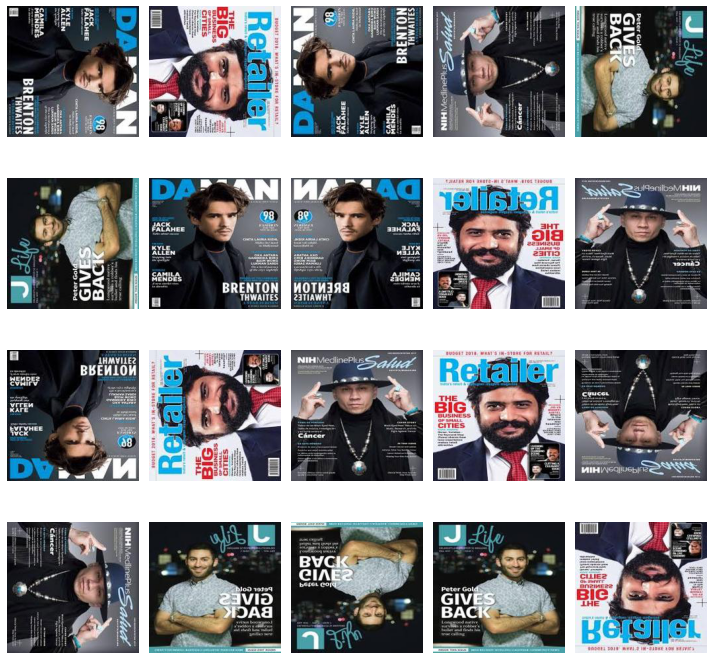

In [ ]:
plt.figure(figsize=(10, 10))
showable = [filename for filename in train_non_bio_images_afda if '5758' in filename]

for i, image_filename in enumerate(showable):
  ax = plt.subplot(4, 5, i + 1)
  img_path = os.path.join(train_dir, 'N', image_filename)
  img = plt.imread(img_path)
  plt.imshow(img)
  plt.axis("off")

plt.tight_layout()
plt.show()

Here are the first nine images from the training dataset.

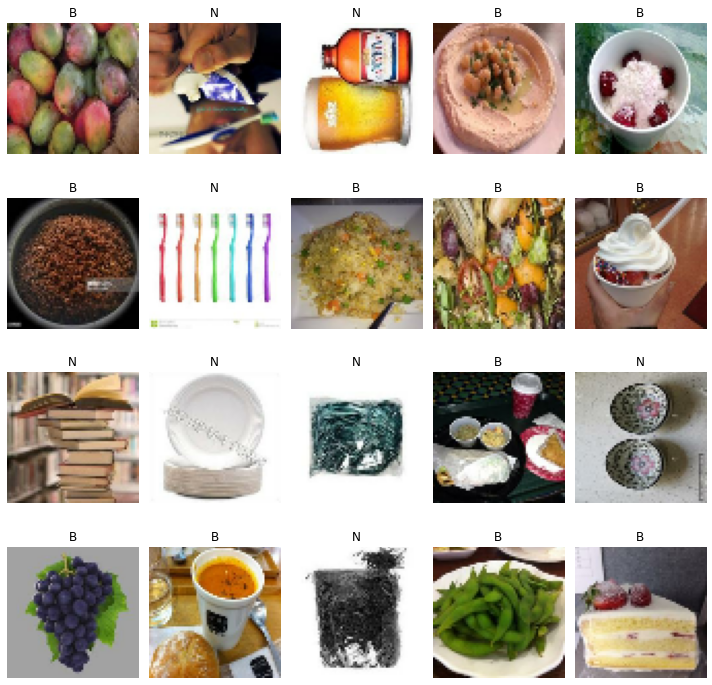

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32, 1)


The image_batch is a tensor of the shape (32, 64, 64, 3). This is a batch of 32 images of shape 64x64x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32, 1), these are corresponding labels to the 32 images.

In [ ]:
image_batch, labels_batch = next(train_ds.as_numpy_iterator())
first_image = image_batch[0].astype(int)

# The pixel values are between 0 and 255.
print(f"Pixels are between {np.min(first_image)} and {np.max(first_image)}")

Pixels are between 0 and 255


## Standardize the data

In [ ]:
normalization_layer = Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(normalized_ds.as_numpy_iterator())
first_image = image_batch[0].astype(int)
# Notice that now pixel values are in `[0, 1]`.
print(f"Notice that now pixels are between {np.min(first_image)} and {np.max(first_image)}")

Notice that now pixels are between 0 and 1


## Performance Optimization

In [ ]:
# Prefetch, Overlaps the Preprocessing and Model Execution of a Training Step. Reading +1 batch of current batch execution. 
# Reduce Latency because Pipeline Reading Data when It Execute.

# Cache, Create Cache File of Dataset in Memory or Disk.
# Use .cache() to Create Cache on Memory. Faster, but Resource Consuming.
# Use .cache(dir_to_file) to Create Cache on Specific Directory on Disk.

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Modeling

In [ ]:
metrics = ['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score(num_classes=1, average='weighted', threshold=0.5), AUC(name='auc')]

In [ ]:
def get_callbacks(model_name): 
  filepath = f'models/tmp/{model_name}-model.h5'
  return [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True),
    TensorBoard(log_dir=f'logs/{model_name}')
  ]

In [ ]:
def plot_epochs_against_loss(history, n_epochs, ax):
  epochs = range(1, n_epochs + 1)

  val_loss = history.history['val_loss'][:n_epochs]

  ax.plot(epochs, val_loss, label='Validation Loss')
  ax.plot(epochs, history.history['loss'][:n_epochs], label='Training Loss')

  min_val_loss_idx, min_val_loss = np.argmin(val_loss), min(val_loss)

  ax.plot(min_val_loss_idx + 1, min_val_loss, '.', c='black', markersize=12)

  ax.set(xlabel='Epochs', ylabel='Binary Cross Entropy')
  ax.grid()

  ax.legend()

def plot_epochs_against_metric(history, metric, n_epochs, ax):
  epochs = range(1, n_epochs + 1)
  label = ' '.join([w.capitalize() for w in metric.split('_')])

  val_metric_loss = history.history[f'val_{metric}'][:n_epochs]

  ax.plot(epochs, val_metric_loss, label=f'Validation {label}')
  ax.plot(epochs, history.history[metric][:n_epochs], label=f'Training {label}')

  max_val_metric_loss_idx, max_val_metric_loss = np.argmax(val_metric_loss), max(val_metric_loss)

  ax.plot(max_val_metric_loss_idx + 1, max_val_metric_loss, '.', c='black', markersize=12)

  ax.set(xlabel='Epochs', ylabel=label)
  ax.grid()

  ax.legend()

def plot_epochs_against_metrics_and_loss(history, n_epochs=25, title=None):
  f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20, 8))

  plot_epochs_against_loss(history, n_epochs, ax0)
  plot_epochs_against_metric(history, 'accuracy', n_epochs, ax1)
  
  # f, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(30, 12))

  plot_epochs_against_metric(history, 'precision', n_epochs, ax2)
  plot_epochs_against_metric(history, 'recall', n_epochs, ax3)
  plot_epochs_against_metric(history, 'f1_score', n_epochs, ax4)

  if title:
    f.suptitle(title)

  f.tight_layout()
  plt.show()

In [ ]:
def show_predictions(model, test_ds):
  y_pred = model.predict(test_ds)

  plt.figure(figsize=(15, 10))

  for images, labels in test_ds.take(1):
    for i in range(25):

      img, confidence = images[i], y_pred[i, 0]
      actual, predicted = int(labels[i, 0]), 0 if confidence < 0.5 else 1
      
      ax = plt.subplot(5, 5, i + 1)
      ax.imshow(images[i].numpy().astype("uint8"))
      color = "green" if actual == predicted else "red"
      ax.set_title(test_ds.class_names[actual], color=color)
      ax.set(xticks=[], yticks=[])

  plt.tight_layout()
  plt.show()

In [ ]:
def print_results(model, test_ds, model_name):
  [loss, acc, precision, recall, f1_score, auc] = model.evaluate(test_ds)

  print(f"Transfer Learning Model using {model_name}")
  print(f"  - Accuracy: {acc :.2%}")
  print(f"  - Precision: {precision :.2%}")
  print(f"  - Recall: {recall :.2%}")
  print(f"  - F1 Score: {f1_score :.2%}")

  return model_name, acc, precision, recall, f1_score, auc

In [ ]:
def true_and_predicted_labels(model, test_ds):
  y_pred = []  # store predicted labels
  y_true = []  # store true labels

  # iterate over the dataset
  for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = (model.predict(image_batch).flatten() > 0.5).astype(np.uint8)
    # append predicted labels
    y_pred.append(preds)

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)

  return correct_labels, predicted_labels

In [ ]:
def show_confusion_matrix(y=None, y_predicted=None, labels=[0, 1], cm=None):
  f, ax = plt.subplots()

  if cm is None:
    cm = confusion_matrix(y, y_predicted, labels=labels)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="RdPu", values_format='.0f', ax=ax)

  plt.grid(False)
  plt.suptitle("Confusion Matrix")
  plt.show()

## Baseline Model

In [ ]:
input_shape = image_size[:2] + (3,)

if os.path.exists('baseline-model.h5'):
  baseline_model = load_model('baseline-model.h5')
else:
  baseline_model = Sequential([
    Rescaling(1/255, input_shape=input_shape),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
  ])

In [ ]:
baseline_model.input_shape, baseline_model.output_shape

((None, 64, 64, 3), (None, 1))

In [ ]:
baseline_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_2242 (Conv2D)        (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2243 (Conv2D)        (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2244 (Conv2D)        (None, 12, 12, 64)      

In [ ]:
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
EPOCHS = 10
baseline_history = baseline_model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=16,
  epochs=EPOCHS,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds))

Epoch 1/10
5993/5993 [==============================] - 138s 23ms/step - loss: 0.2308 - accuracy: 0.9079 - precision: 0.9047 - recall: 0.9121 - f1_score: 0.9084 - auc: 0.9672 - val_loss: 0.1870 - val_accuracy: 0.9269 - val_precision: 0.9044 - val_recall: 0.9541 - val_f1_score: 0.9286 - val_auc: 0.9789
Epoch 2/10
5993/5993 [==============================] - 58s 10ms/step - loss: 0.1733 - accuracy: 0.9335 - precision: 0.9293 - recall: 0.9385 - f1_score: 0.9339 - auc: 0.9809 - val_loss: 0.1598 - val_accuracy: 0.9396 - val_precision: 0.9315 - val_recall: 0.9484 - val_f1_score: 0.9399 - val_auc: 0.9839
Epoch 3/10
5993/5993 [==============================] - 55s 9ms/step - loss: 0.1512 - accuracy: 0.9425 - precision: 0.9381 - recall: 0.9476 - f1_score: 0.9428 - auc: 0.9853 - val_loss: 0.1603 - val_accuracy: 0.9396 - val_precision: 0.9518 - val_recall: 0.9256 - val_f1_score: 0.9385 - val_auc: 0.9848
Epoch 4/10
5993/5993 [==============================] - 55s 9ms/step - loss: 0.1348 - accuracy

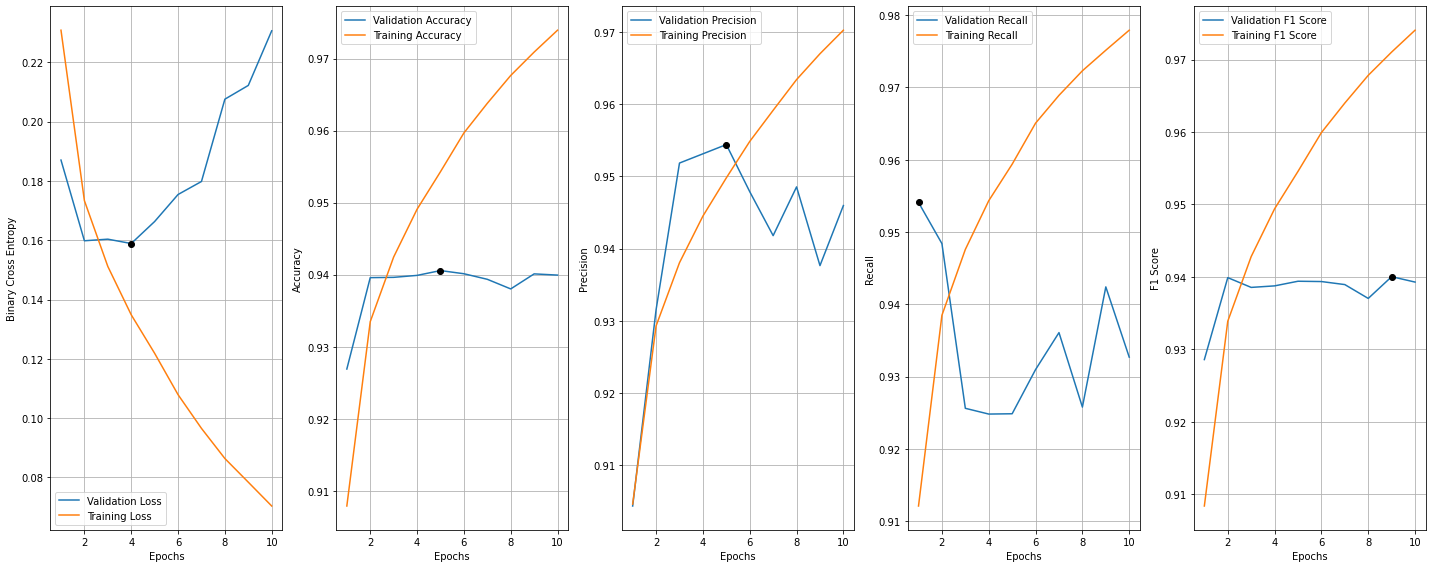

In [ ]:
plot_epochs_against_metrics_and_loss(baseline_history, n_epochs=EPOCHS)

In [ ]:
test_ds = image_dataset_from_directory(
  directory=test_dir,
  label_mode='binary',
  labels='inferred',
  color_mode=color_mode,
  batch_size=batch_size,
  image_size=image_size)

Found 16726 files belonging to 2 classes.


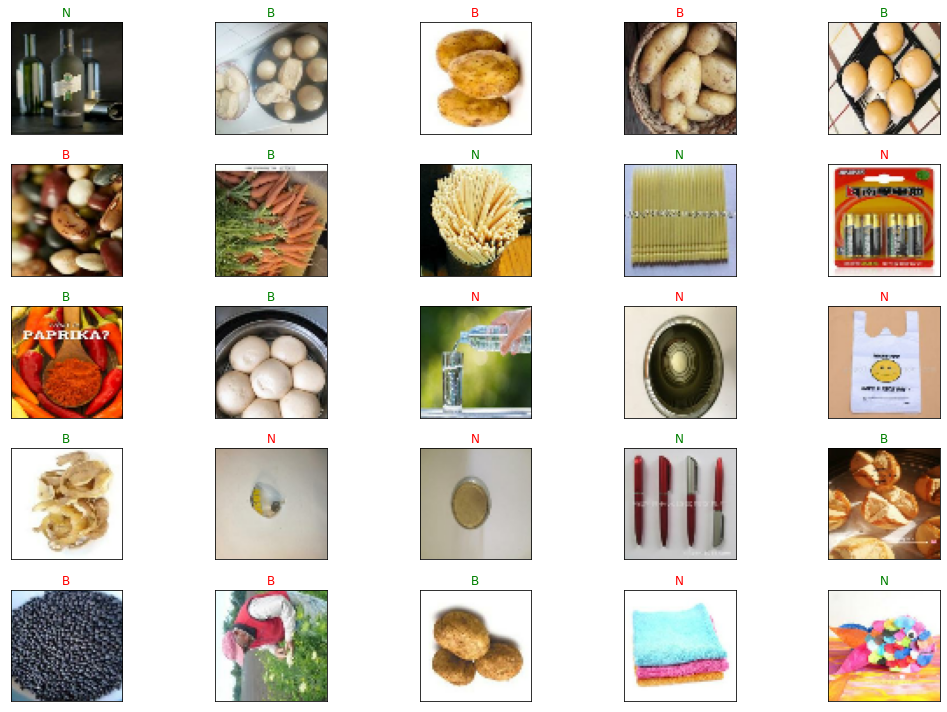

In [ ]:
show_predictions(baseline_model, test_ds)

In [ ]:
baseline_results = print_results(baseline_model, test_ds, 'Baseline')

523/523 [==============================] - 7s 13ms/step - loss: 0.4409 - accuracy: 0.8773 - precision: 0.8420 - recall: 0.9290 - f1_score: 0.8833 - auc: 0.9457
Transfer Learning Model using Baseline
  - Accuracy: 87.73%
  - Precision: 84.20%
  - Recall: 92.90%
  - F1 Score: 88.33%


In [ ]:
correct_labels, predicted_labels = true_and_predicted_labels(baseline_model, test_ds)

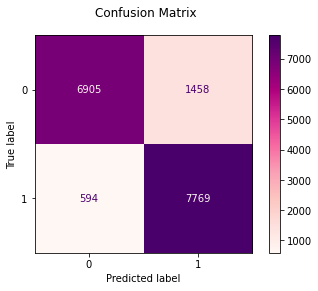

In [ ]:
cm = tf.math.confusion_matrix(correct_labels, predicted_labels).numpy()
show_confusion_matrix(cm=cm)

In [ ]:
y_true, y_baseline_pred = true_and_predicted_labels(baseline_model, test_ds)
print(classification_report(y_true, y_baseline_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87      8363
         1.0       0.84      0.93      0.88      8363

    accuracy                           0.88     16726
   macro avg       0.88      0.88      0.88     16726
weighted avg       0.88      0.88      0.88     16726



In [ ]:
baseline_model.save('baseline-model-final.h5')

In [ ]:
! cp 'baseline-model-final.h5' 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/'

#### Naive Approach vs. Baseline Model

##### Before the Data Augmentation (with the imbalance)

In [ ]:
total_bfda = len(test_bio_images_bfda) + len(test_non_bio_images_bfda)
len(test_bio_images_bfda) / total_bfda, len(test_non_bio_images_bfda) / total_bfda

In [ ]:
y_test_bfda = np.concatenate([np.zeros(len(test_bio_images_bfda)), np.ones(len(test_non_bio_images_bfda))])
y_naive_preds_bfda = np.ones(y_test_bfda.shape)

print(f"Accuracy: {accuracy_score(y_test_bfda, y_naive_preds_bfda)}")
print(f"Recall: {recall_score(y_test_bfda, y_naive_preds_bfda)}")
print(f"Precision: {precision_score(y_test_bfda, y_naive_preds_bfda)}")
print(f"F1 Score: {f1_score(y_test_bfda, y_naive_preds_bfda)}")

In [ ]:
show_confusion_matrix(y_test_bfda, y_naive_preds_bfda)

##### After the Data Augmentation

In [ ]:
total_afda = len(test_bio_images_afda) + len(test_non_bio_images_afda)
len(test_bio_images_afda) / total_afda, len(test_non_bio_images_afda) / total_afda

In [ ]:
y_test_afda = np.concatenate([np.zeros(len(test_bio_images_afda)), np.ones(len(test_non_bio_images_afda))])
y_naive_preds_afda = np.ones(y_test_afda.shape)

print(f"Accuracy: {accuracy_score(y_test_afda, y_naive_preds_afda)}")
print(f"Recall: {recall_score(y_test_afda, y_naive_preds_afda)}")
print(f"Precision: {precision_score(y_test_afda, y_naive_preds_afda)}")
print(f"F1 Score: {f1_score(y_test_afda, y_naive_preds_afda)}")

In [ ]:
show_confusion_matrix(y_test_afda, y_naive_preds_afda)

## VGG16

In [ ]:
! mkdir -p models/tmp
! mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
if os.path.exists('vgg16-model.h5'):
  from_vgg_model = load_model('vgg16-model.h5')
else:
  vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=input_shape)

  from_vgg_model = Sequential([
    Rescaling(1/255, input_shape=input_shape),
    vgg_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

  vgg_model.trainable = False

  from_vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
from_vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
filepath = 'models/tmp/vgg16-model.h5'

callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True),
  TensorBoard(log_dir='logs/vgg16')
]

from_vgg_history = from_vgg_model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=16,
  epochs=50,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds),
  callbacks=callbacks)

Epoch 1/50
5993/5993 [==============================] - 102s 17ms/step - loss: 0.2123 - accuracy: 0.9159 - precision: 0.9071 - recall: 0.9201 - f1_score: 0.9135 - auc: 0.9686 - val_loss: 0.1840 - val_accuracy: 0.9284 - val_precision: 0.9390 - val_recall: 0.9157 - val_f1_score: 0.9272 - val_auc: 0.9806
Epoch 2/50
5993/5993 [==============================] - 99s 17ms/step - loss: 0.1831 - accuracy: 0.9285 - precision: 0.9253 - recall: 0.9325 - f1_score: 0.9289 - auc: 0.9791 - val_loss: 0.1683 - val_accuracy: 0.9347 - val_precision: 0.9405 - val_recall: 0.9275 - val_f1_score: 0.9340 - val_auc: 0.9829
Epoch 3/50
5993/5993 [==============================] - 99s 17ms/step - loss: 0.1709 - accuracy: 0.9344 - precision: 0.9312 - recall: 0.9382 - f1_score: 0.9347 - auc: 0.9817 - val_loss: 0.1631 - val_accuracy: 0.9370 - val_precision: 0.9377 - val_recall: 0.9357 - val_f1_score: 0.9367 - val_auc: 0.9836
Epoch 4/50
5993/5993 [==============================] - 99s 17ms/step - loss: 0.1633 - accura

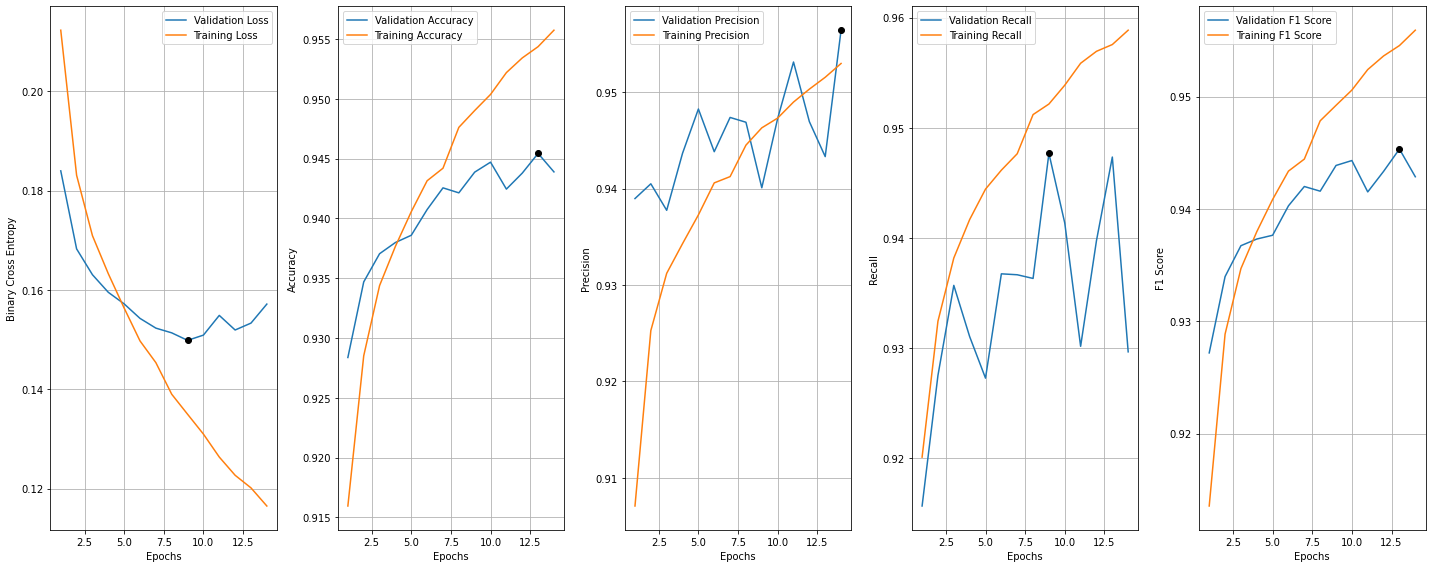

In [ ]:
plot_epochs_against_metrics_and_loss(from_vgg_history, n_epochs=len(from_vgg_history.history['accuracy']))

In [ ]:
%tensorboard --logdir logs

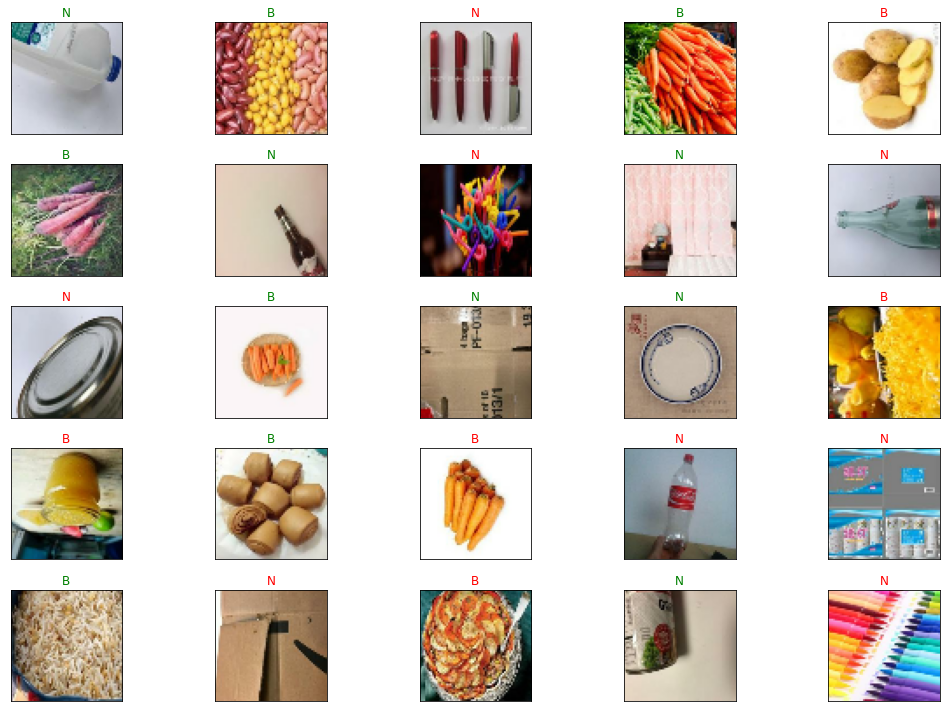

In [ ]:
show_predictions(from_vgg_model, test_ds)

In [ ]:
from_vgg_results = print_results(from_vgg_model, test_ds, 'VGG16')

523/523 [==============================] - 8s 15ms/step - loss: 0.3258 - accuracy: 0.8704 - precision: 0.8246 - recall: 0.9409 - f1_score: 0.8789 - auc: 0.9549
Transfer Learning Model using VGG16
  - Accuracy: 87.04%
  - Precision: 82.46%
  - Recall: 94.09%
  - F1 Score: 87.89%


In [ ]:
y_true, y_from_vgg_pred = true_and_predicted_labels(from_vgg_model, test_ds)
print(classification_report(y_true, y_from_vgg_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      8363
         1.0       0.82      0.94      0.88      8363

    accuracy                           0.87     16726
   macro avg       0.88      0.87      0.87     16726
weighted avg       0.88      0.87      0.87     16726



In [ ]:
from_vgg_model.save('vgg16-model-final.h5')

In [ ]:
! cp 'vgg16-model-final.h5' 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/'

### Fine Tuning

In [ ]:
vgg_model.trainable = True

for layer in vgg_model.layers[:15]:
  layer.trainable = False

vgg_fine_tuned_model = Sequential([
  vgg_model,
  Flatten(),
  Dense(512, activation='relu'),
  Dropout(0.5),
  Dense(256, activation='relu'),
  Dense(1, activation='sigmoid')
])

vgg_fine_tuned_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
filepath = 'models/tmp/vgg16-fine-tuned-model.h5'

callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True),
  TensorBoard(log_dir='logs')
]

vgg_fine_tuned_history = vgg_fine_tuned_model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=16,
  epochs=50,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds),
  callbacks=callbacks)

In [ ]:
plot_epochs_against_metrics_and_loss(vgg_fine_tuned_history, n_epochs=len(vgg_fine_tuned_history.history['accuracy']))

In [ ]:
show_predictions(vgg_fine_tuned_model, test_ds)

In [ ]:
print_results(vgg_fine_tuned_model, test_ds, 'VGG16 Fine-Tuned')

## EfficientNet

In [ ]:
if os.path.exists('efficientnet-model.h5'):
  from_efficientnet_model = load_model('efficientnet-model.h5')
else:
  efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, input_shape=input_shape, weights="imagenet")

  from_efficientnet_model = Sequential([
    efficientnet_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

  efficientnet_model.trainable = False

  from_efficientnet_model.compile(optimizer=RMSprop(learning_rate=0.0001, decay=1e-6), loss='binary_crossentropy', metrics=metrics)

In [ ]:
filepath = 'models/tmp/efficientnet-model.h5'

callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True),
  TensorBoard(log_dir='logs/efficientnet')
]

from_efficientnet_history = from_efficientnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds),
  callbacks=callbacks)

Epoch 1/50
5993/5993 [==============================] - 146s 23ms/step - loss: 0.1616 - accuracy: 0.9447 - precision: 0.9303 - recall: 0.9486 - f1_score: 0.9394 - auc: 0.9813 - val_loss: 0.1481 - val_accuracy: 0.9532 - val_precision: 0.9521 - val_recall: 0.9540 - val_f1_score: 0.9530 - val_auc: 0.9856
Epoch 2/50
5993/5993 [==============================] - 133s 22ms/step - loss: 0.1476 - accuracy: 0.9528 - precision: 0.9490 - recall: 0.9573 - f1_score: 0.9531 - auc: 0.9858 - val_loss: 0.1463 - val_accuracy: 0.9564 - val_precision: 0.9528 - val_recall: 0.9600 - val_f1_score: 0.9564 - val_auc: 0.9859
Epoch 3/50
5993/5993 [==============================] - 133s 22ms/step - loss: 0.1393 - accuracy: 0.9563 - precision: 0.9522 - recall: 0.9610 - f1_score: 0.9566 - auc: 0.9871 - val_loss: 0.1446 - val_accuracy: 0.9576 - val_precision: 0.9577 - val_recall: 0.9572 - val_f1_score: 0.9574 - val_auc: 0.9864
Epoch 4/50
5993/5993 [==============================] - 133s 22ms/step - loss: 0.1338 - acc

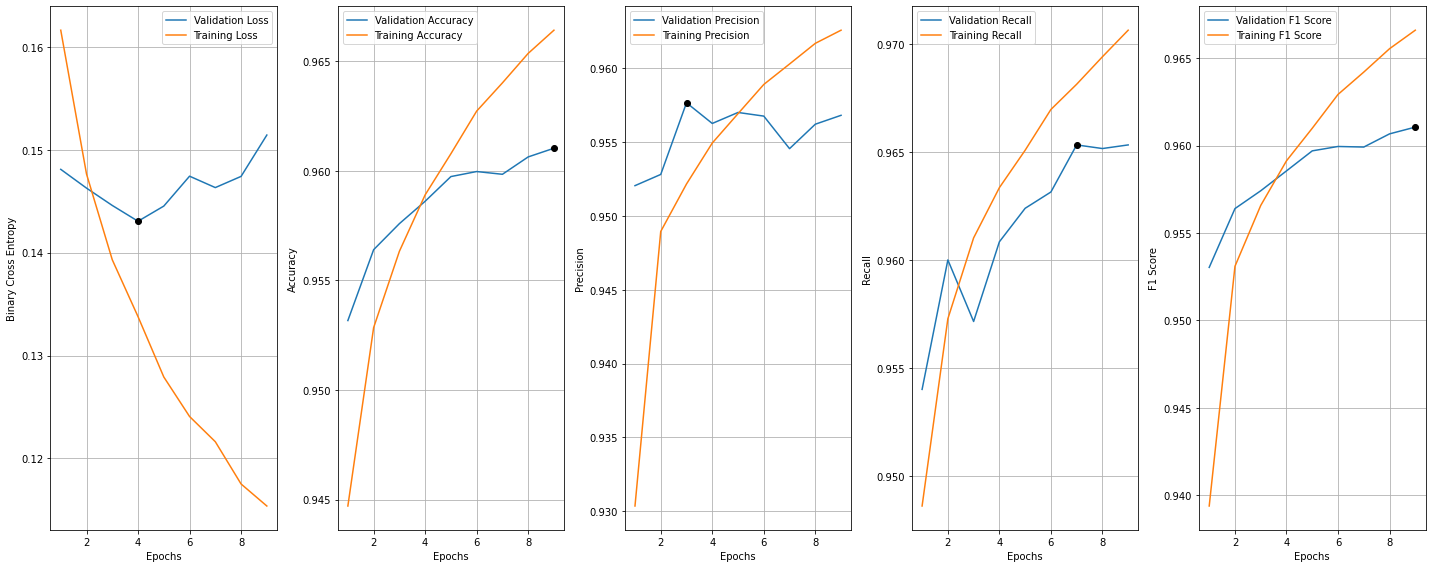

In [ ]:
plot_epochs_against_metrics_and_loss(from_efficientnet_history, n_epochs=len(from_efficientnet_history.history['accuracy']))

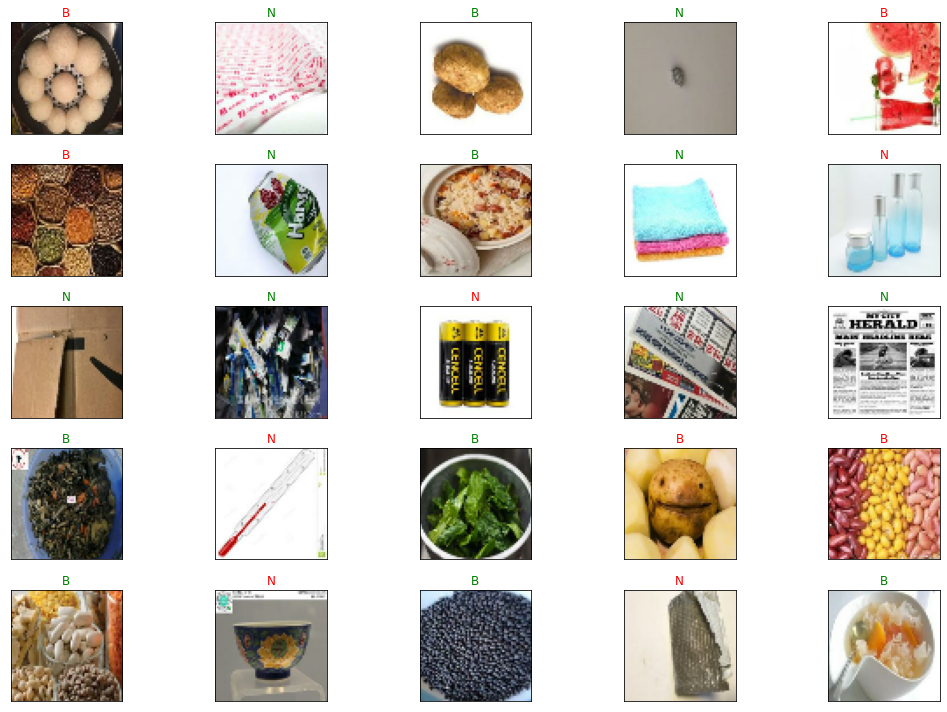

In [ ]:
show_predictions(from_efficientnet_model, test_ds)

In [ ]:
from_efficientnet_results = print_results(from_efficientnet_model, test_ds, 'ResNet 50')

523/523 [==============================] - 12s 23ms/step - loss: 0.3186 - accuracy: 0.9007 - precision: 0.8671 - recall: 0.9464 - f1_score: 0.9050 - auc: 0.9584
Transfer Learning Model using ResNet 50
  - Accuracy: 90.07%
  - Precision: 86.71%
  - Recall: 94.64%
  - F1 Score: 90.50%


In [ ]:
y_true, y_from_efficientnet_pred = true_and_predicted_labels(from_efficientnet_model, test_ds)
print(classification_report(y_true, y_from_efficientnet_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.85      0.90      8363
         1.0       0.87      0.95      0.91      8363

    accuracy                           0.90     16726
   macro avg       0.90      0.90      0.90     16726
weighted avg       0.90      0.90      0.90     16726



In [ ]:
from_efficientnet_model.save('efficientnet-model-final.h5')

In [ ]:
! cp 'efficientnet-model-final.h5' 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/'

## Inception

In [ ]:
input_shape = (75, 75, 3)
image_size = input_shape[:2]

train_ds_inception = image_dataset_from_directory(
  directory=train_dir,
  label_mode='binary',
  labels='inferred',
  color_mode=color_mode,
  seed=seed,
  validation_split=0.2,
  subset='training',
  image_size=image_size,
  batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)

val_ds_inception = image_dataset_from_directory(
  directory=train_dir,
  label_mode='binary',
  labels='inferred',
  color_mode=color_mode,
  seed=seed,
  validation_split=0.2,
  subset='validation',
  image_size=image_size,
  batch_size=batch_size).cache().prefetch(buffer_size=AUTOTUNE)

Found 239690 files belonging to 2 classes.
Using 191752 files for training.
Found 239690 files belonging to 2 classes.
Using 47938 files for validation.


In [ ]:
if os.path.exists('inception-v3-model.h5'):
  from_inception_v3_model = load_model('inception-v3-model.h5')
else:
  inception_v3_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, input_shape=input_shape)

  from_inception_v3_model = Sequential([
    Rescaling(1/255, input_shape=input_shape),
    inception_v3_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])

  inception_v3_model.trainable = False

  from_inception_v3_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=metrics)

In [ ]:
filepath = 'models/tmp/inception-v3-model.h5'

callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True),
  TensorBoard(log_dir='logs/inceptionv3')
]

from_inception_v3_history = from_inception_v3_model.fit(
  train_ds_inception,
  validation_data=val_ds_inception,
  epochs=50,
  steps_per_epoch=len(train_ds_inception),
  validation_steps=len(val_ds_inception),
  callbacks=callbacks)

Epoch 1/50
5993/5993 [==============================] - 237s 37ms/step - loss: 0.2245 - accuracy: 0.9137 - precision: 0.9079 - recall: 0.9209 - f1_score: 0.9144 - auc: 0.9694 - val_loss: 0.1914 - val_accuracy: 0.9279 - val_precision: 0.9213 - val_recall: 0.9351 - val_f1_score: 0.9281 - val_auc: 0.9770
Epoch 2/50
5993/5993 [==============================] - 172s 29ms/step - loss: 0.1805 - accuracy: 0.9341 - precision: 0.9290 - recall: 0.9401 - f1_score: 0.9345 - auc: 0.9797 - val_loss: 0.1858 - val_accuracy: 0.9335 - val_precision: 0.9290 - val_recall: 0.9381 - val_f1_score: 0.9336 - val_auc: 0.9787
Epoch 3/50
5993/5993 [==============================] - 171s 29ms/step - loss: 0.1626 - accuracy: 0.9431 - precision: 0.9379 - recall: 0.9492 - f1_score: 0.9435 - auc: 0.9834 - val_loss: 0.1869 - val_accuracy: 0.9352 - val_precision: 0.9293 - val_recall: 0.9414 - val_f1_score: 0.9354 - val_auc: 0.9791
Epoch 4/50
5993/5993 [==============================] - 170s 28ms/step - loss: 0.1482 - acc

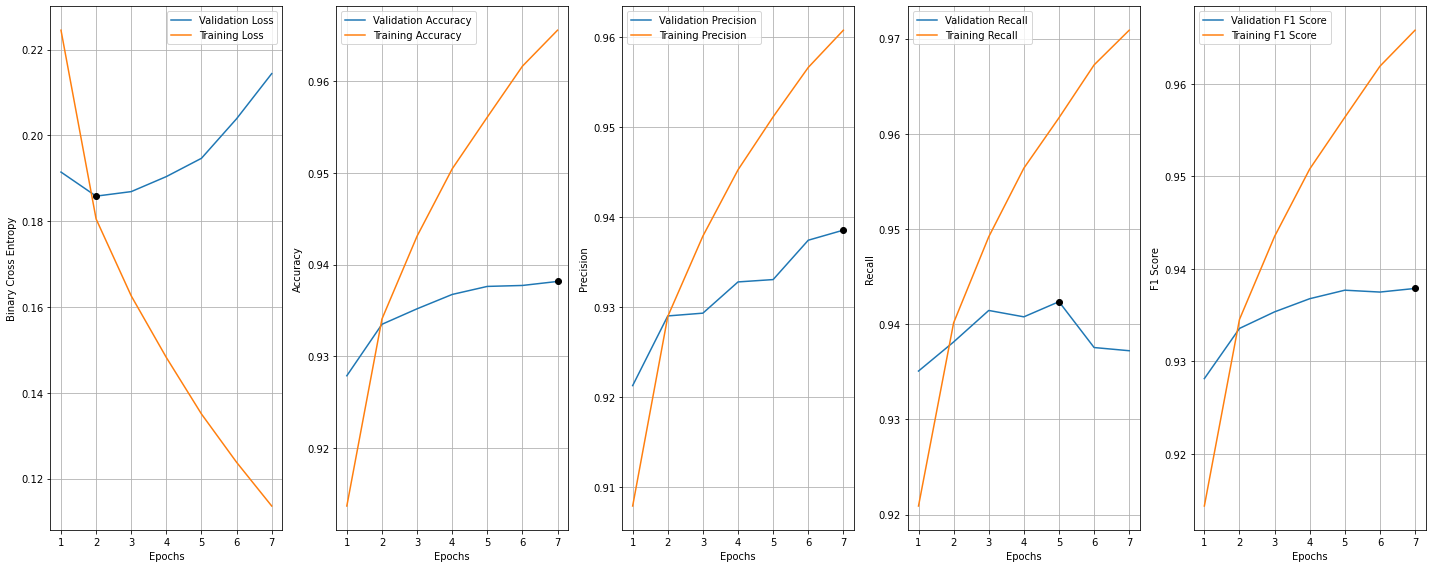

In [ ]:
plot_epochs_against_metrics_and_loss(from_inception_v3_history, n_epochs=len(from_inception_v3_history.history['accuracy']))

In [ ]:
test_ds_inception = image_dataset_from_directory(
  directory=test_dir,
  label_mode='binary',
  labels='inferred',
  color_mode=color_mode,
  batch_size=batch_size,
  image_size=image_size)

Found 16726 files belonging to 2 classes.


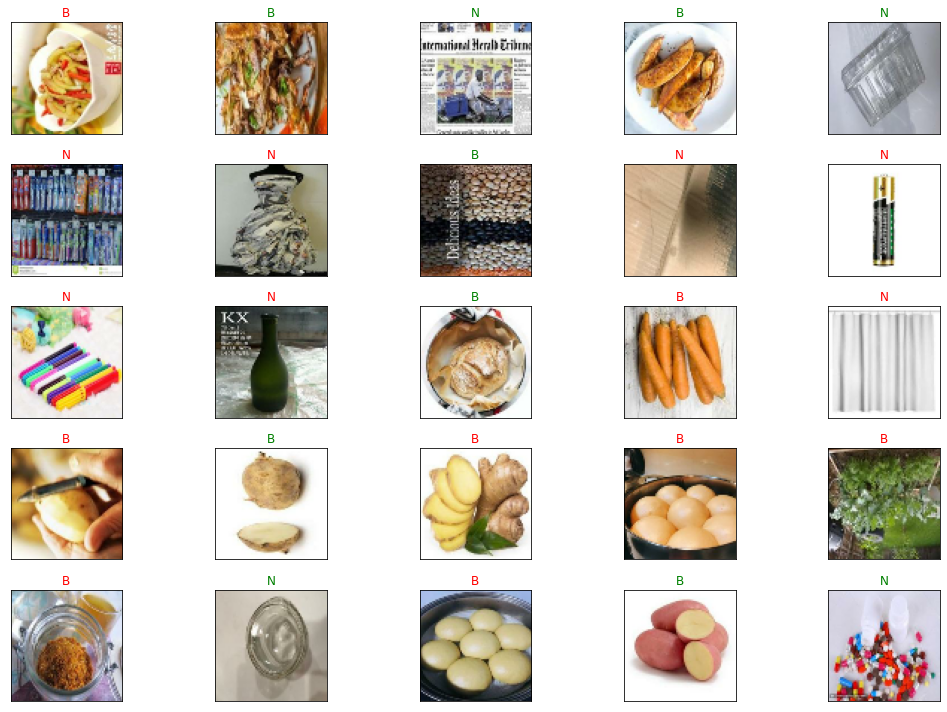

In [ ]:
show_predictions(from_inception_v3_model, test_ds_inception)

In [ ]:
from_inception_v3_results = print_results(from_inception_v3_model, test_ds_inception, 'Inception V3')

523/523 [==============================] - 15s 29ms/step - loss: 0.3218 - accuracy: 0.8721 - precision: 0.8296 - recall: 0.9365 - f1_score: 0.8798 - auc: 0.9525
Transfer Learning Model using Inception V3
  - Accuracy: 87.21%
  - Precision: 82.96%
  - Recall: 93.65%
  - F1 Score: 87.98%


In [ ]:
y_true, y_from_inception_v3_pred = true_and_predicted_labels(from_inception_v3_model, test_ds_inception)
print(classification_report(y_true, y_from_inception_v3_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.81      0.86      8363
         1.0       0.83      0.94      0.88      8363

    accuracy                           0.87     16726
   macro avg       0.88      0.87      0.87     16726
weighted avg       0.88      0.87      0.87     16726



In [ ]:
from_inception_v3_model.save('inception-v3-model-final.h5')

In [ ]:
! cp 'inception-v3-model-final.h5' 'gdrive/MyDrive/Courses/ITC - Fellows Data Science/ITC Fellows DS - Final Project (Group 1)/'

# ROC Curve Analysis

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
baseline_results

('Baseline',
 0.8678703904151917,
 0.8236036896705627,
 0.9362668991088867,
 0.8763290643692017,
 0.9434522390365601)

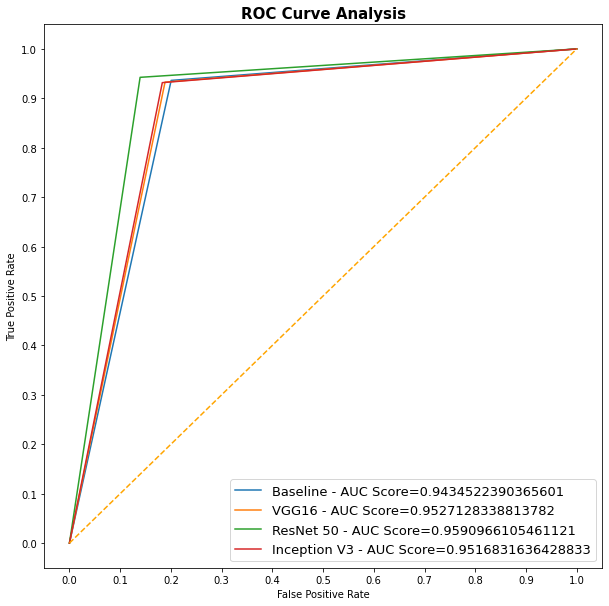

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))

def plot_roc_curve(prefix, test_ds, ax):
  [model_name, _, _, _, _, auc_score] = eval(f'{prefix}_results')
  model = eval(f'{prefix}_model')
  y_true, y_pred = true_and_predicted_labels(model, test_ds)

  fpr, tpr, threshold = roc_curve(y_true, y_pred)
  ax.plot(fpr, tpr, label=f'{model_name} - AUC Score={auc_score}')

for prefix in ['baseline', 'from_vgg', 'from_efficientnet', 'from_inception_v3']:
  if 'inception' in prefix:
    plot_roc_curve(prefix, test_ds_inception, ax)
    continue

  plot_roc_curve(prefix, test_ds, ax)

ax.plot([0, 1], [0, 1], color='orange', linestyle='--')

ax.set(xticks=np.arange(0.0, 1.1, step=0.1), xlabel="False Positive Rate", yticks=np.arange(0.0, 1.1, step=0.1), ylabel="True Positive Rate")

ax.set_title('ROC Curve Analysis', fontweight='bold', fontsize=15)

ax.legend(prop={'size': 13}, loc='lower right')

plt.show()

# Presentation

In [ ]:
! pip install gradio -q

     |████████████████████████████████| 649 kB 5.2 MB/s 
     |████████████████████████████████| 210 kB 66.1 MB/s 
     |████████████████████████████████| 1.1 MB 60.9 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 255 kB 60.6 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 2.0 MB 38.6 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 271 kB 64.0 MB/s 
     |████████████████████████████████| 144 kB 67.2 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
     |████████████████████████████████| 10.9 MB 38.2 MB/s 
     |████████████████████████████████| 79 kB 6.1 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 3.6 MB 53.8 MB/s 
     |████████████████████████████████| 61 kB 443 kB/s 
     |████████████████████████

In [ ]:
import gradio as gr

In [ ]:
def classify_image(model):
  def fn_classify_image(img):
    inp = img.reshape((-1, 64, 64, 3))
    confidence = model.predict(inp).flatten()
    outputs = {0: '🌱 Biodegradable', 1: '💀 Non-biodegradable'}
    return outputs[int(confidence >= 0.5)]
  return fn_classify_image

In [ ]:
# ! pip install shap -q
# import shap

In [ ]:
image = gr.inputs.Image(shape=(64, 64))
# interpretation="shap"
iface = gr.Interface(fn=classify_image(baseline_model), inputs=image, outputs="text", interpretation="default")
debug=True
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://43316.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f7d279ffc90>,
 'http://127.0.0.1:7861/',
 'https://43316.gradio.app')

# Flush and Unmount Google Drive

In [ ]:
drive.flush_and_unmount()

# More (useful) Resources

- Image Classification Fine-Tuning: https://huggingface.co/tasks/image-classification